<a href="https://colab.research.google.com/github/mmedlin1997/cifar10/blob/master/cifar_10_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 19, 2020

@author: mark

REF: https://www.youtube.com/watch?v=ixathu7U-LQ&t=17s
REF: https://www.cs.toronto.edu/~kriz/cifar.html
"""
#%% Import
import torch
import torchvision
from torchvision import datasets, transforms  # image data, transform to torch tensor format 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from datetime import timedelta

from platform import python_version
print("python", python_version())
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("matplotlib", matplotlib.__version__)
print("seaborn", sns.__version__)

python 3.6.9
torch 1.6.0+cu101
torchvision 0.7.0+cu101
matplotlib 3.2.2
seaborn 0.10.1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**torchvision.datasets** - common datasets (ex MNIST, COCO)

**ToTensor()** - A torchvision transform. Converts PIL Image or numpy.ndarray to tensor. Specifically, converts RGB or UINT8 (HxWxC) in range [0, 255] to torch.FloatTensor of shape (CxHxW) in the range [0.0, 1.0].

**Compose([])** - list of chained transforms

In [4]:
train = datasets.MNIST('', train=True, download=True, 
                      transform=transforms.Compose([
                          transforms.ToTensor()
                      ]))
test = datasets.MNIST('', train=False, download=True, 
                      transform=transforms.Compose([
                          transforms.ToTensor()
                      ]))
print(train)

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!
Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**torch.utils.data.DataLoader(dataset, batch_size (int, opt), shuffle (bool, opt))** - returns iterable over dataset. Can set batch size every epoch, and whether to shuffle every epoch. 

In [5]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

In [6]:
train_iter = iter(train_loader)                      # make iterable out of loader object

# verify dimensions of first batch (ex1: using iterable)
train_images, train_labels = train_iter.next()       # get next iteration
print("Image batch dimensions:", train_images.shape) # tensor size [batch_size, 1, h, w]
print("Image label dimensions:", train_labels.shape)

# verify dimensions of first batch (ex2: using loader in loop)
for train_images, train_labels in train_loader:
    print("Image batch dimensions:", train_images.shape)
    print("Image label dimensions:", train_labels.shape)
    break



Image batch dimensions: torch.Size([10, 1, 28, 28])
Image label dimensions: torch.Size([10])
Image batch dimensions: torch.Size([10, 1, 28, 28])
Image label dimensions: torch.Size([10])


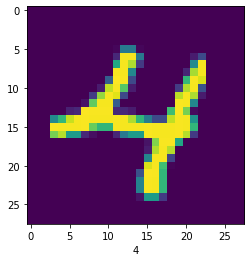

In [7]:
# show one image
index = 0
plt.imshow(train_images[index].view(28,28))
plt.xlabel(train_labels[index].item()) # labels are tensors, get value with item()
plt.show()

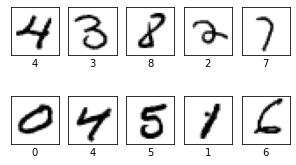

In [8]:


#%% Preview dataset
plt.figure(figsize=(5,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].view(28,28), cmap=plt.cm.binary) # reshape tensor(1,28,28) to matplotlib shape(28,28) 
    plt.xlabel(train_labels[i].item()) # labels are tensors, get value with item()
plt.show()

Create a class to define the NN model.


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    # Define layers
    self.fc1 = nn.Linear(28*28, 64) # Linear - fully-connected layer (input, output). This layer is input, designed to take a single image.
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, 64)
    self.fc4 = nn.Linear(64, 10)

  # Define how data flows forward through nn, and activations
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    logits = self.fc4(x)
    out = F.log_softmax(logits, dim=1)
    return out

model = Model()

# verify model with single random image
X = torch.randn((28,28))
X = X.view(-1, 28*28)
out = model(X)
out

tensor([[-2.2861, -2.3291, -2.1982, -2.2623, -2.3635, -2.3818, -2.4479, -2.3269,
         -2.1945, -2.2645]], grad_fn=<LogSoftmaxBackward>)

Train model

In [50]:
import torch.optim as optim

# optimizer_name(specify unfrozen weights, learning rate)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3
losses, times = [], []
for epoch in range(epochs):
  start = timer() 
  for train_images, train_labels in train_loader:   # data is a batch of images and labels           
    model.zero_grad()                               # reset gradients instead summing of every backpropagation
    output = model(train_images.view(-1, 28*28))    # pass (batch) images thru model
    loss = F.nll_loss(output, train_labels)         # loss function
    loss.backward()                                 # backpropagate
    optimizer.step()                                # optimizer step toward global minimum
  end = timer()
  time = timedelta(seconds=end-start)
  losses.append(loss)
  times.append(time)
  print('epoch:', epoch, 'loss:', loss.item(), 'time:', time)
print(losses, times)

epoch: 0 loss: 0.00014137559628579766 time: 0:00:17.268437
epoch: 1 loss: 9.119268725044094e-06 time: 0:00:17.490360
epoch: 2 loss: 7.195359648903832e-05 time: 0:00:17.672330
[tensor(0.0001, grad_fn=<NllLossBackward>), tensor(9.1193e-06, grad_fn=<NllLossBackward>), tensor(7.1954e-05, grad_fn=<NllLossBackward>)] [datetime.timedelta(0, 17, 268437), datetime.timedelta(0, 17, 490360), datetime.timedelta(0, 17, 672330)]


Test model

In [25]:
correct, total = 0, 0

with torch.no_grad():      # do not allocate memory for gradient calculations on model 
    for data in test_loader:
        test_images, test_labels = data
        output = model(test_images.view(-1,784))
        #print(output)
        for idx, i in enumerate(output):
            #print(idx, i, torch.argmax(i), y[idx])
            if torch.argmax(i) == test_labels[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.968


Save model as PyTorch

In [61]:
checkpoint = {'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Load model as PyTorch

In [64]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(checkpoint.keys())
print(checkpoint['model_state_dict'].keys())
print(checkpoint['optimizer_state_dict'].keys())

dict_keys(['model_state_dict', 'optimizer_state_dict'])
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])
dict_keys(['state', 'param_groups'])


Results

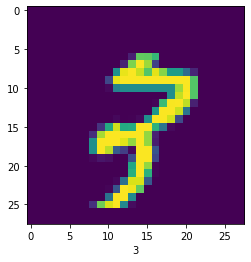

In [65]:
# Inspect one result
index = 5
expected = test_labels[index].item()
inferred = torch.argmax(model(test_images[index].view(-1,784))[0]).item()
plt.imshow(test_images[index].view(28,28))
plt.xlabel(inferred)
plt.show()

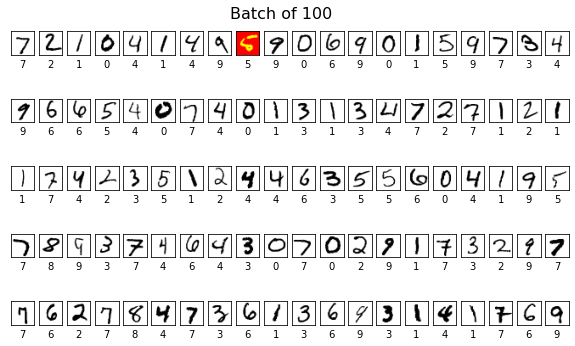

In [66]:
# Inspect batch
batch_size = 100
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
plt.figure(figsize=(10,6))
for test_images, test_labels in test_loader:
  output = model(test_images.view(-1,784))  
  for i, img in enumerate(output):
    expected = test_labels[i]
    inferred = torch.argmax(model(test_images[i].view(-1,784))[0])
    cmap = plt.cm.binary if expected == inferred else plt.cm.autumn
    plt.subplot(batch_size/20, 20, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].view(28,28), cmap=cmap) 
    plt.xlabel(expected.item())
    plt.suptitle('Batch of ' + str(batch_size), fontsize=16, y=.9)
  break
plt.show()

Total test digits: 2064
Predicted distribution: tensor([257, 110, 253, 253, 209, 145, 200, 246, 158, 233])
Actual distribution: tensor([212, 111, 264, 242, 214, 124, 190, 260, 206, 241])


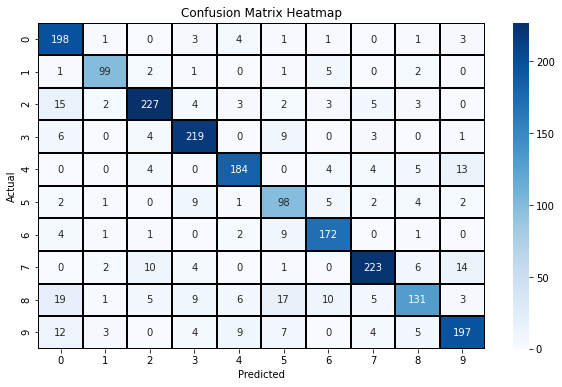

In [47]:
#%% Confusion Matrix
# Inspect batch
batch_size = 100
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

num_classes = 10
class_names = [i for i in range(10)]
cf_matrix = torch.zeros((num_classes, num_classes), dtype=torch.uint8)

for test_images, test_labels in test_loader:
  output = model(test_images.view(-1,784))  
  for i, img in enumerate(output):
    expected = test_labels[i]
    inferred = torch.argmax(model(test_images[i].view(-1,784))[0])
    cf_matrix[expected][inferred] += 1

plt.figure(figsize=(10,6))
ax = sns.heatmap(cf_matrix, annot=True, 
                 yticklabels=class_names, xticklabels=class_names, fmt='', 
                 linewidths=1, linecolor='k', cmap='Blues')
ax.set(title="Confusion Matrix Heatmap", xlabel="Predicted", ylabel="Actual",)

print('Total test digits:', cf_matrix.sum().item())
print('Predicted distribution:', cf_matrix.sum(0))
print('Actual distribution:', cf_matrix.sum(1))

In [63]:
model = Model()

for train_images, train_labels in train_loader:
  print("batch size:", train_images.shape)
  for image in train_images:
    print("image size:", image.shape)
    image = image.view(image.shape[0], -1) # flatten
    print("image size:", image.shape)
    out = model(image)
    print(out.shape)
  break

batch size: torch.Size([10, 1, 28, 28])
image size: torch.Size([1, 28, 28])
image size: torch.Size([1, 784])
torch.Size([1, 10])
image size: torch.Size([1, 28, 28])
image size: torch.Size([1, 784])
torch.Size([1, 10])
image size: torch.Size([1, 28, 28])
image size: torch.Size([1, 784])
torch.Size([1, 10])
image size: torch.Size([1, 28, 28])
image size: torch.Size([1, 784])
torch.Size([1, 10])
image size: torch.Size([1, 28, 28])
image size: torch.Size([1, 784])
torch.Size([1, 10])
image size: torch.Size([1, 28, 28])
image size: torch.Size([1, 784])
torch.Size([1, 10])
image size: torch.Size([1, 28, 28])
image size: torch.Size([1, 784])
torch.Size([1, 10])
image size: torch.Size([1, 28, 28])
image size: torch.Size([1, 784])
torch.Size([1, 10])
image size: torch.Size([1, 28, 28])
image size: torch.Size([1, 784])
torch.Size([1, 10])
image size: torch.Size([1, 28, 28])
image size: torch.Size([1, 784])
torch.Size([1, 10])


Torch tutorial

In [14]:
x = torch.rand((4,5))
x = torch.randn((4,5))
x = torch.zeros((4,5))
x = torch.ones((2,4,5))
print(x)
print(x.size())
print(x.dtype)
print(x.shape)
print(x.shape[0])
x = torch.Tensor([[1,2],[3,4]])
print(x)
y = x.clone()
print(x*y)
y=y.view(4,1)
print(y/y)

tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]])
torch.Size([2, 4, 5])
torch.float32
torch.Size([2, 4, 5])
2
tensor([[1., 2.],
        [3., 4.]])
tensor([[ 1.,  4.],
        [ 9., 16.]])
tensor([[1.],
        [1.],
        [1.],
        [1.]])


In [15]:
a = torch.rand((2,5)) * 10
print(a)
b = a.view(-1,2)
print(b)
b = a.transpose(0,1)
print(b)
c = a.unsqueeze(1)
print(c, c.shape)

tensor([[4.8818, 4.2736, 9.5697, 7.9988, 9.6750],
        [7.1080, 0.9800, 3.9901, 6.5185, 3.2446]])
tensor([[4.8818, 4.2736],
        [9.5697, 7.9988],
        [9.6750, 7.1080],
        [0.9800, 3.9901],
        [6.5185, 3.2446]])
tensor([[4.8818, 7.1080],
        [4.2736, 0.9800],
        [9.5697, 3.9901],
        [7.9988, 6.5185],
        [9.6750, 3.2446]])
tensor([[[4.8818, 4.2736, 9.5697, 7.9988, 9.6750]],

        [[7.1080, 0.9800, 3.9901, 6.5185, 3.2446]]]) torch.Size([2, 1, 5])
